# Introduction

* Theme:Building smart ocean,enabling the modernization of maritime security governance capability.
* Background:The application of AIS、Beidou terminal and some other equipments has brought great convenience to maritime traffic, but at the time, there are a lot of losses because of  misuse of equipment.
* Target:Based on the data from Beidou, we need to classify the type among gillnets、trawlnet and pursenet.

# Part1: Read data

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import time
import numpy as np
import os
import warnings
import datetime
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import warnings
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [ ]:
train=pd.read('/home/aistudio/data/data19361/hy_round1_train_20200102')
test=pd.read('/home/aistudio/data/data19361/hy_round1_testA_20200102')
data=train.append(test)
data.reset_index(drop=True)
data=data.rename(columns={'渔船ID':'ship','lat':'x','lon':'y','速度':'v','方向':'d'})

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
data=reduce_mem_usage(data, verbose=True)

# Part2: Overview the data

In [ ]:
data1=data[data['type']=='刺网']
data2=data[data['type']=='拖网']
data3=data[data['type']=='围网']
data4=data[(data['type']==None]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(data4['x'], data4['y'], marker='o')
plt.scatter(data3['x'], data3['y'], marker='o')
plt.scatter(data2['x'], data2['y'], marker='o')
plt.scatter(data1['x'], data1['y'], marker='o')
plt.show()

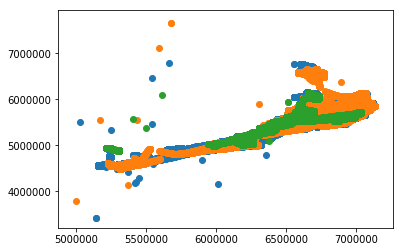

**we see:**
* the line is lumped, so maybe we can assumed that they have similar port
* different type has different line
* distribution of samples is uneven

# Part3: Base statistical features

In [ ]:
def group_feature(df, key, target, aggs):   
    agg_dict = {}
    for ag in aggs:
        agg_dict[f'{target}_{ag}'] = ag
    t = df.groupby(key)[target].agg(agg_dict).reset_index()
    return t

data_label=data.drop_duplicates('ship')[['type','ship']].reset_index(drop=True)

t = group_feature(data, 'ship','x',['max','min','mean','std','skew'])
data_label= pd.merge(data_label, t, on='ship', how='left')
t = group_feature(data, 'ship','y',['max','min','mean','std','skew'])
data_label= pd.merge(data_label, t, on='ship', how='left')
t = group_feature(data, 'ship','v',['max','min','mean','std','skew'])
data_label= pd.merge(data_label, t, on='ship', how='left')
t = group_feature(data, 'ship','d',['max','mean','std','skew'])
data_label= pd.merge(data_label, t, on='ship', how='left')
t = group_feature(data, 'ship','x',['count'])
data_label = pd.merge(data_label, t, on='ship', how='left')
t = group_feature(data, 'ship','y',['count'])
data_label = pd.merge(data_label, t, on='ship', how='left')

data_label['v_max_v_min']=data_label['v_max'] -data_label['v_min']
data_label['x_max_x_min'] = data_label['x_max'] -data_label['x_min']
data_label['y_max_y_min'] = data_label['y_max'] - data_label['y_min']
data_label['y_max_x_min'] = data_label['y_max'] - data_label['x_min']
data_label['x_max_y_min'] = data_label['x_max'] - data_label['y_min']
data_label['slope'] =data_label['y_max_y_min'] / np.where(data_label['x_max_x_min']==0, 0.001, data_label['x_max_x_min'])
data_label['area'] = data_label['x_max_x_min'] *data_label['y_max_y_min']


data_label['x_max_x_min|mean']=data_label['x_max_x_min']/data_label['x_mean']
data_label['y_max_y_min|mean']=data_label['y_max_y_min']/data_label['y_mean']
data_label['v_max_v_min|mean']=data_label['v_max_v_min']/data_label['v_mean']

data_label['y_mean|x_mean']=data_label['y_mean']/data_label['x_mean']
data_label['x_max_x_min|y_max_y_min']=data_label['x_max_x_min']/data_label['y_max_y_min']
data_label['x_max_x_min|v_mean']=data_label['x_max_x_min']/data_label['v_mean']
data_label['y_max_y_min|v_mean']=data_label['y_max_y_min']/data_label['v_mean']

#quantile
for feat in ['x','y','v']:
    for num in [0.1,0.2,0.8,0.9]: 
        t = data.groupby('ship')[feat].agg({f'{feat}_quanti_{num}':lambda x:x.quantile(num)}).reset_index()
        data_label = pd.merge(data_label, t, on='ship', how='left')
for num in [0.1,0.2,0.8,0.9]:
        data_label[f'{feat}_{num}|mean']=data_label[f'{feat}_quanti_{num}']/data_label[f'{feat}_mean']


In [ ]:
#get diff
data['time']=pd.to_datetime(datai['time'], format='%m%d %H:%M:%S')
data=data.sort_values(by='time').reset_index(drop=True)
data['deta_v']= data['v'].diff(1)
data['deta_x']=data['x'].diff(1)
data['deta_y']=data['y'].diff(1)
data['deta_d']=data['d'].diff(1)
data['deta_t']=(data['time'].diff(1)).dt.total_seconds()

t = group_feature(data, 'ship','deta_x',['max','min','mean','std','skew'])
data_label= pd.merge(data_label, t, on='ship', how='left')
t = group_feature(data, 'ship','deta_y',['max','min','mean','std','skew'])
data_label= pd.merge(data_label, t, on='ship', how='left')
t = group_feature(data, 'ship','deta_v',['max','min','mean','std','skew'])
data_label= pd.merge(data_label, t, on='ship', how='left')
t = group_feature(data, 'ship','deta_d',['max','mean','std','skew'])
data_label= pd.merge(data_label, t, on='ship', how='left')

In [ ]:
#consider of time
data['date'] = data['time'].dt.date
data['hour'] =data['time'].dt.hour
data['weekday'] =data['time'].dt.weekday

mode_hour = data.groupby('ship')['hour'].agg(lambda x:x.value_counts().index[0]).to_dict()
data_label['mode_hour'] =data_label['ship'].map(mode_hour)
t = group_feature(data, 'ship','hour',['max','min'])
data_label = pd.merge(data_label, t, on='ship', how='left')
hour_nunique = data.groupby('ship')['hour'].nunique().to_dict()
date_nunique = data.groupby('ship')['date'].nunique().to_dict()
data_label['hour_nunique'] = data_label['ship'].map(hour_nunique)
data_label['date_nunique'] = data_label['ship'].map(date_nunique)

# Part4: Segmental features

In [ ]:
for feat in ['x','y','v','d']:
    data[f'deta_{feat}_t']=data[f'deta_{feat}'].apply(lambda x:abs(x))*100/data['deta_t']
data['deta_xy_t']=data['deta_x'].apply(lambda x:abs(x))+data['deta_y'].apply(lambda x:abs(x))

#consider of d
data['deta_d']=data['deta_d'].abs()
data['deta_x_t']=data['deta_x_t'].abs()
data['deta_y_t']=data['deta_y_t'].abs()
data['deta_v_t']=data['deta_v_t'].abs()
d0=data[data['deta_d']==0]
d1=data[(data['deta_d']>0) & (datai['deta_d']<10)]
d2=data[data['deta_d']>10]
for i,group in enumerate([d0,d1,d2]):
    for feat in ['deta_x_t','deta_y_t','deta_v_t','v']:
        t=group.groupby('ship')[feat].agg({f'{feat}_detad{i}_mean':'mean'}).reset_index()
        data_label= pd.merge(data_label, t, on='ship', how='left')

#consider of v        
v0=data[data['v']<datai['v'].quantile(0.3)] 
v1=data[data['v']>datai['v'].quantile(0.7)] 
for i,group in enumerate([v0,v1]):
    t = group.groupby('ship')['v'].agg({f'v{i}_mean':'mean'}).reset_index()                         
    data_label= pd.merge(data_label, t, on='ship', how='left')
    t = group.groupby('ship')['x'].agg({f'x{i}_max_mean':lambda x:x.max()-x.min()}).reset_index()                         
    data_label= pd.merge(data_label, t, on='ship', how='left')
    t = group.groupby('ship')['y'].agg({f'y{i}_max_mean':lambda x:x.max()-x.min()}).reset_index()                         
    data_label= pd.merge(data_label, t, on='ship', how='left')   
    t = group.grouppby('ship')['deta_d_t'].agg({f'deta_d{i}_mean':lambda x:x.abs().mean()}).reset_index()                         
    data_label= pd.merge(data_label, t, on='ship', how='left') 

# Part5: Port and Mode

In [ ]:
for f in ['x','y']:  
    t=data.groupby('ship')[f].agg({'stay_pos_{}'.format(f):lambda x : x.value_counts().index[0]}).reset_index()
    data_label= pd.merge(data_label, t, on='ship', how='left')
    data_label['stay_pos_dis_{}'.format(f)] = data_label['{}_max'.format(f)] - data_label['stay_pos_{}'.format(f)]
    if f == 'y':
        data_label['stay_pos_dis_line'] = (data_label['stay_pos_dis_x']**2 + data_label['stay_pos_dis_y']**2)**0.5
        print('stay_pos_dis_line')    
    #assuming that boats have the similar port
    if f == 'x':
        data_label['stay_base_{}'.format(f)] = data_label['stay_pos_{}'.format(f)] -data['x'].mode()[0]
    if f == 'y':
        data_label['stay_base_{}'.format(f)] = data_label['stay_pos_{}'.format(f)] -data['y'].mode()[0]
        
    data_label['stay_base_area'] = data_label['stay_base_x'].abs()*data_label['stay_base_y'].abs()
    data_label['stay_base_distance'] = (data_label['stay_base_x']**2 + data_label['stay_base_y']**2)**0.5
    print('stay_base_distance')        
   
    print('stay_ratiao_y')
    if f == 'y':
        t=data.groupby(['ship'])['y'].apply(lambda x : x.value_counts().iloc[0])/ data.groupby(['ship'])['y'].count()
        t.name= 'stay_ratiao_y'
        data_label= pd.merge(data_label, t, on='ship', how='left')

# Part6:Embedding

**Combine longitude and latitude**

In [ ]:
!pip install gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence 
import multiprocessing 
from tqdm import tqdm
import numpy as np

data['x']=data['x'].astype(int)
data['y']=data['y'].astype(int)
data['v']=data['v'].astype(int)
data['d']=data['d'].astype(int)

data['x_y']=data['x'].astype(str)+'_'+data['y'].astype(str)

In [ ]:
def emb(data, f2):
    emb_size =5
    tmp = data.groupby('ship', as_index=False)[f2].agg({'{}_list'.format(f2): list})
    sentences = tmp['{}_list'.format(f2)].values.tolist()
    del tmp['{}_list'.format( f2)]
    for i in range(len(sentences)):
        sentences[i] = [str(x) for x in sentences[i]]
    model = Word2Vec(sentences, size=emb_size, window=5, min_count=3, sg=0, hs=1, seed=2019)
    emb_matrix = []
    for seq in sentences:
        vec = []
        for w in seq:
            if w in model:
                vec.append(model[w])
        if len(vec) > 0:
            emb_matrix.append(np.mean(vec, axis=0))
        else:
            emb_matrix.append([0] * emb_size)
    emb_matrix = np.array(emb_matrix)
    for i in range(emb_size):
        tmp['{}_emb_{}'.format(f2, i)] = emb_matrix[:, i]
    del model, emb_matrix, sentences
    return tmp
for feat in ['x','y','v','d','x_y']:
    t=emb(data,feat)
    data_label=pd.merge(data_label,t, on='ship', how='left')

# Part7:Train the modle

In [ ]:
train=data_label[~data_label['type'].isnull()]
test=data_label[data_label['type'].isnull()]
type_map = {'拖网':0,'围网':1,'刺网':2}
type_map_rev = {v:k for k,v in type_map.items()}
train['type'] = train['type'].map(type_map)

In [ ]:
train.reset_index(drop=True)
test.reset_index(drop=True)

In [ ]:
features = [x for x in train.columns if x not in ['ship','type']]
target = 'type'

params = {
    'num_boost_round': 100,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 50,
}
pred_list=[]
for state in range(40,45):
    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=state )
    X = train[features].copy()
    y = train[target]
    models = []
    pred = np.zeros((len(test_label),3))
    oof = np.zeros((len(X), 3))
    for index, (train_idx, val_idx) in enumerate(fold.split(X, y)):
        train_set = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])
        val_set = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx])
        model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=100)
        models.append(model)
        val_pred = model.predict(X.iloc[val_idx])
        oof[val_idx] = val_pred
        val_y = y.iloc[val_idx]
        val_pred = np.argmax(val_pred, axis=1)
        print(index, 'val f1', metrics.f1_score(val_y, val_pred, average='macro'))
        
        test_pred = model.predict(test_label[features])
        pred += test_pred/5

    pred_list.append(pred)

pred=sum(pred_list)/len(pred_list)
pred = np.argmax(pred, axis=1)
sub = test[['ship']]
sub['pred'] = pred
print(sub['pred'].value_counts())
sub['pred'] = sub['pred'].map(type_map_rev)
sub.to_csv('result.csv', header=None, index=False)

# Part8: Balance the weights

In [ ]:
params = {
    'n_estimators': 3000,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'early_stopping_rounds': 100}
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
X = train[features].copy()
y = train[target]
pred = np.zeros((len(test),3))
oof = np.zeros((len(X), 3))
for index, (train_idx, val_idx) in enumerate(fold.split(X, y)):
    train_set = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])
    val_set = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx])
    model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=100)
    # models.append(model)
    val_pred = model.predict(X.iloc[val_idx])
    val_pred = val_pred*np.array([1,1.1,1.05])
    oof[val_idx] = val_pred
    val_y = y.iloc[val_idx]
    val_pred = np.argmax(val_pred, axis=1)
    print(index, 'val f1', metrics.f1_score(val_y, val_pred, average='macro'))
    test_pred = model.predict(test[features])
    test_pred=test_pred*np.array([1,1.1,1.05])
    pred += test_pred/5